In [1]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

In [2]:
experiment = "02_http_constant_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()

In [3]:
"""
Clean the obtained results from the experiments
- Remove unnecessary columns
- Extract metadata from filenames
- Construct and clean data into a pandas.Series object
- Convert data measures in seconds to ms
"""

# Filter columns
required_cols = [
    "StartTime",
    "RequestedQPS",
    "ActualQPS",
    "DurationHistogram",
]


# fortio reports in seconds, convert to miliseconds
multiplier = 1000


# Regex to extract metadata
# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

"""
Reads a fortio results JSON file, cleans the data and returns
it as a pandas.Series
"""
def clean_fortio_results(results_file: pathlib.Path) -> pd.Series :
    # Read the JSON file as pandas series
    s = pd.read_json(results_file, typ="series")

    # Filter unnecesary columns
    s = s[required_cols]

    # Extract metadata from filename and add it to the series
    matches = re.match(name_re, str(results_file.name))
    s["mesh"] = matches[2]
    s["payload"] = matches[4]

    # Extract nested columns in 'DurationHistogram'
    for key, val in s["DurationHistogram"].items():
        s[key] = val
    s = s.drop(["DurationHistogram", "Percentiles"])

    # Convert obervations from seconds to miliseconds
    s.loc[["Min", "Max", "Sum", "Avg"]] *= multiplier

    # Construct Histogram Bins, Counts and Percentiles
    data = s["Data"]

    s["counts"] = [x["Count"] for x in data]
    s["percentages"] = [x["Percent"] for x in data]

    # Bins (default pd.cut function makes them as categoricals of intervals)
    # https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
    # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
    s["categories"]= pd.Categorical([pd.Interval(x["Start"] * multiplier , x["End"] * multiplier) for x in data])
    s["bins"] = [x.left for x in s["categories"]]
    s["bins"].append(s["categories"][-1].right)

    s = s.drop("Data")

    return s


In [4]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""

series = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip resource usage files
        if not re.match("^(http|grpc).*\.json$", file):
            continue

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        res = clean_fortio_results(p)
        series.append(res)

df = pd.DataFrame(series)

# Re-order
df = df[[
    "mesh",
    "RequestedQPS",
    "payload",
    "ActualQPS",
    "StartTime",
    "Count",
    "Min",
    "Max",
    "Sum",
    "Avg",
    "StdDev",
    "counts",
    "percentages",
    "categories",
    "bins",
]]

df["RequestedQPS"] = pd.to_numeric(df["RequestedQPS"])

# Sort
df = df.sort_values(by=["mesh", "RequestedQPS", "payload"], ignore_index=True)
df.head()

Parsing Experiment results:
Exp: 02_http_constant_throughput
Results: 60


,mesh,RequestedQPS,payload,ActualQPS,StartTime,Count,Min,Max,Sum,Avg,StdDev,counts,percentages,categories,bins
0,baseline,1,0,0.966556,2022-06-26T14:46:59.012527933Z,896,0.212188,102.731670,1090.429308,1.216997,0.004302,"[3, 19, 6, 10, 60, 93, 186, 203, 147, 78, 51, ...","[0.33482142857142805, 2.4553571428571432, 3.12...","[(0.21218800000000002, 0.30000000000000004], (...","[0.21218800000000002, 0.30000000000000004, 0.4..."
1,baseline,100,0,99.965428,2022-06-26T15:02:26.350225271Z,89984,0.123825,113.601389,40212.086436,0.446880,0.002561,"[271, 55759, 28699, 3111, 474, 194, 135, 94, 7...","[0.301164651493598, 62.26662517780939, 94.1600...","[(0.12382500000000002, 0.2], (0.2, 0.300000000...","[0.12382500000000002, 0.2, 0.30000000000000004..."
2,baseline,500,0,499.109653,2022-06-26T15:17:26.827088196Z,449214,0.083856,121.101064,162487.939908,0.361716,0.002697,"[11, 283375, 142667, 9830, 2456, 1184, 712, 51...","[0.0024487215447420003, 63.08485487985681, 94....","[(0.083856, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.083856, 0.1, 0.2, 0.30000000000000004, 0.4,..."
3,baseline,1000,0,996.002446,2022-06-26T15:32:27.217672014Z,896434,0.067191,163.404687,266776.385544,0.297597,0.002158,"[2109, 706876, 141085, 15371, 5957, 3760, 2416...","[0.23526550755549203, 79.0894812111098, 94.827...","[(0.067191, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.067191, 0.1, 0.2, 0.30000000000000004, 0.4,..."
4,cilium,1,0,0.966557,2022-06-27T11:51:24.96285821Z,896,0.346019,98.937129,1574.957759,1.757765,0.003515,"[5, 8, 9, 5, 1, 5, 8, 20, 182, 336, 183, 62, 3...","[0.5580357142857141, 1.450892857142857, 2.4553...","[(0.346019, 0.4], (0.4, 0.5], (0.5, 0.60000000...","[0.346019, 0.4, 0.5, 0.6000000000000001, 0.7, ..."


In [5]:
"""
Plotting of the results
- Create grid of subplots
- Plot figures on logarithmic scale (because of outliers)
- Plot Constant Throughput per mesh
"""


def create_constant_throughput_figure(mesh: str, color: str) -> plt.figure:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Set figure title
    fig.suptitle(f"HTTP Constant Throughput - $\\bf{mesh.capitalize()}$", fontsize=18, y=1)

    # Subset the dataframe to only contains rows of the mesh
    data = df[df["mesh"] == mesh]
    data = data.sort_values(["RequestedQPS"])

    # Plot each row as subplot
    for i ,(_, row) in enumerate(data.iterrows()):
        ax = axes[i]

        # Plot data
        binedges = np.array(row["bins"])
        weights = np.array(row["counts"])
        x = (binedges[1:] + binedges[:-1]) / 2.0

        sns.histplot(data=row, x=x, bins=binedges, weights=weights, color="b", ax=ax)

        # Labels
        plot_title = (
            f"RPS: {row['RequestedQPS']}\n"
            f"min: {row['Min']:.2f} ms, avg: {row['Avg']:.2f} ms, max: {row['Max']:.2f} ms"
        )
        ax.set_ylabel("Request Count")
        ax.set_xlabel("Latency in ms")
        ax.set_title(plot_title, y=1.05)


        # Y AXIS
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


        # X AXIS
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


        # # Second plot with cumulative density
        ax2 = ax.twinx()
        ax2.set_alpha(0.5)
        ax2.grid(False)
        sns.ecdfplot(data=row, x=x, weights=weights, color="orange", ax=ax2)

    fig.tight_layout()
    return fig

/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/4292932679.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


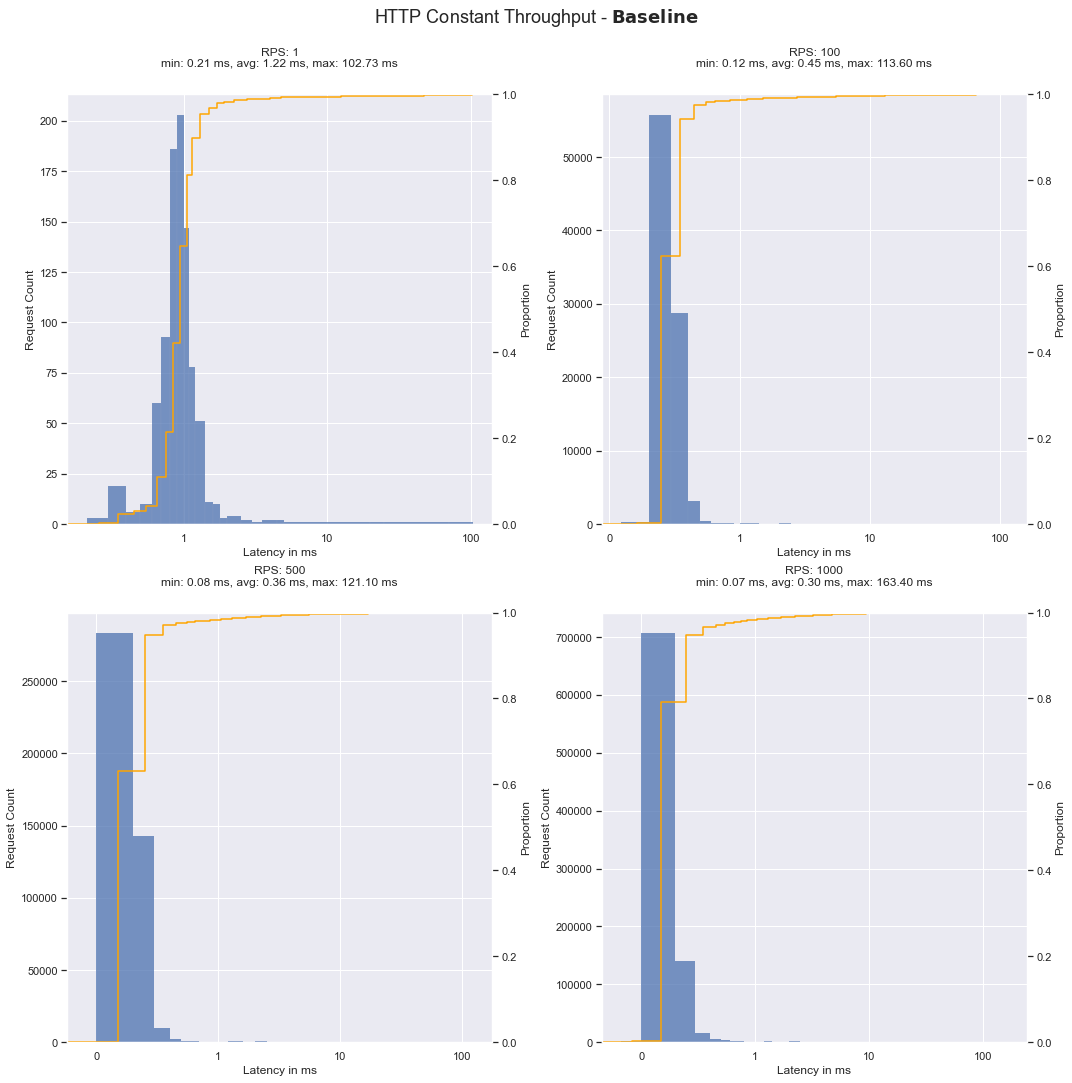

In [6]:
fig = create_constant_throughput_figure("baseline", "b")
fig.savefig(plot_dir / "exp_02-latency-baseline-results.pdf")
fig.show()

/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/2063568212.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


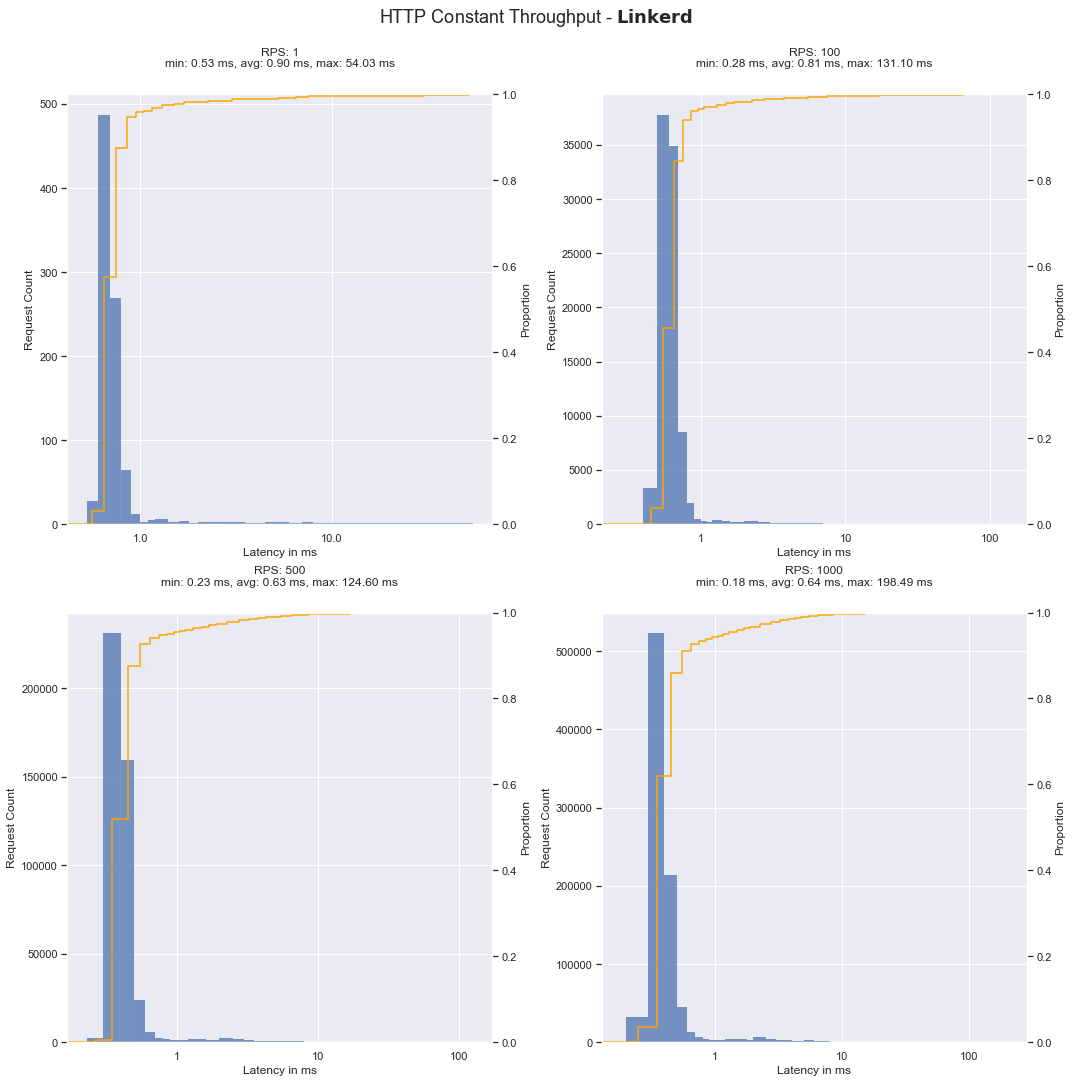

In [7]:
fig = create_constant_throughput_figure("linkerd", "b")
fig.savefig(plot_dir / "exp_02-latency-linkerd-results.pdf")
fig.show()

/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/264982304.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


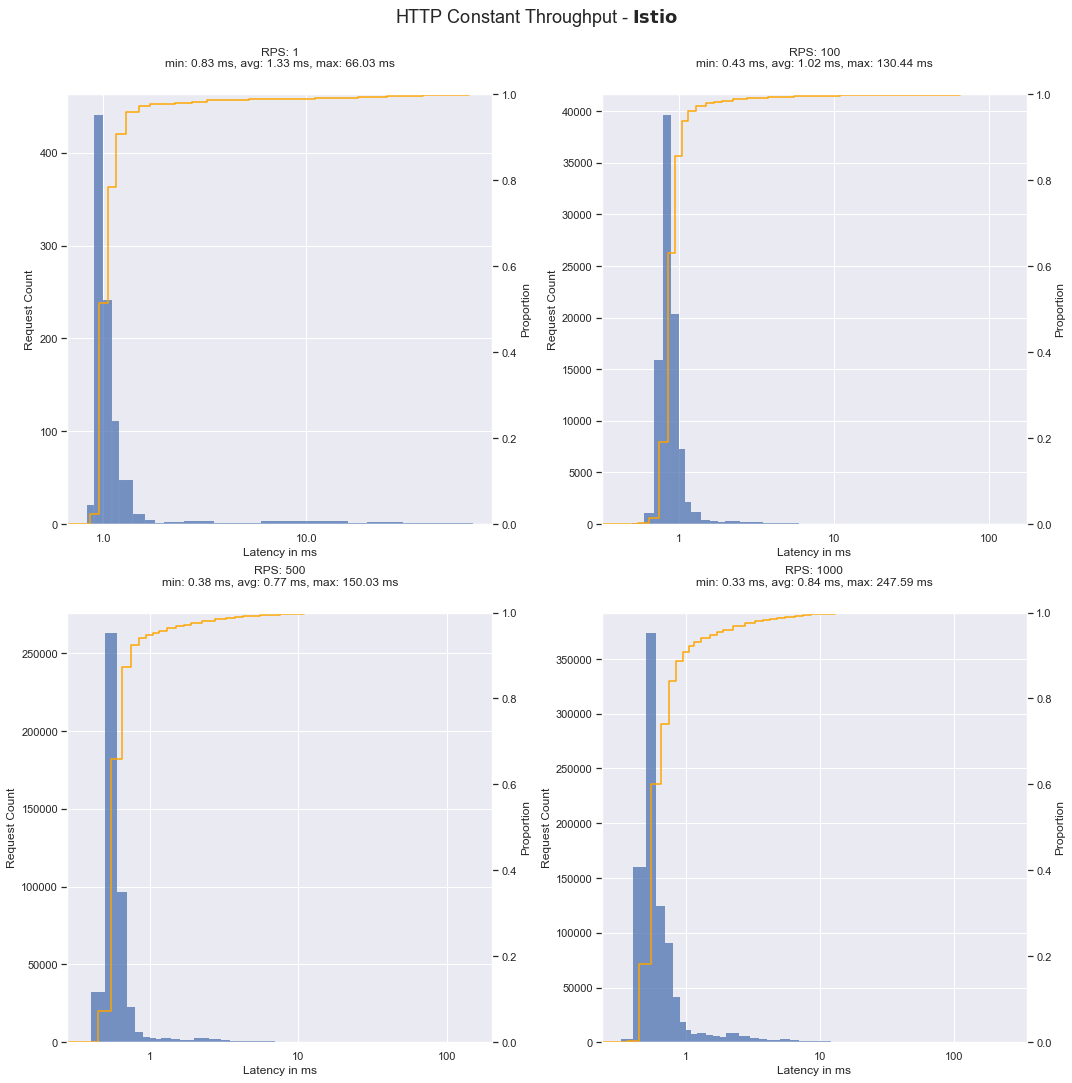

In [8]:
fig = create_constant_throughput_figure("istio", "b")
fig.savefig(plot_dir / "exp_02-latency-istio-results.pdf")
fig.show()

/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/782179000.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


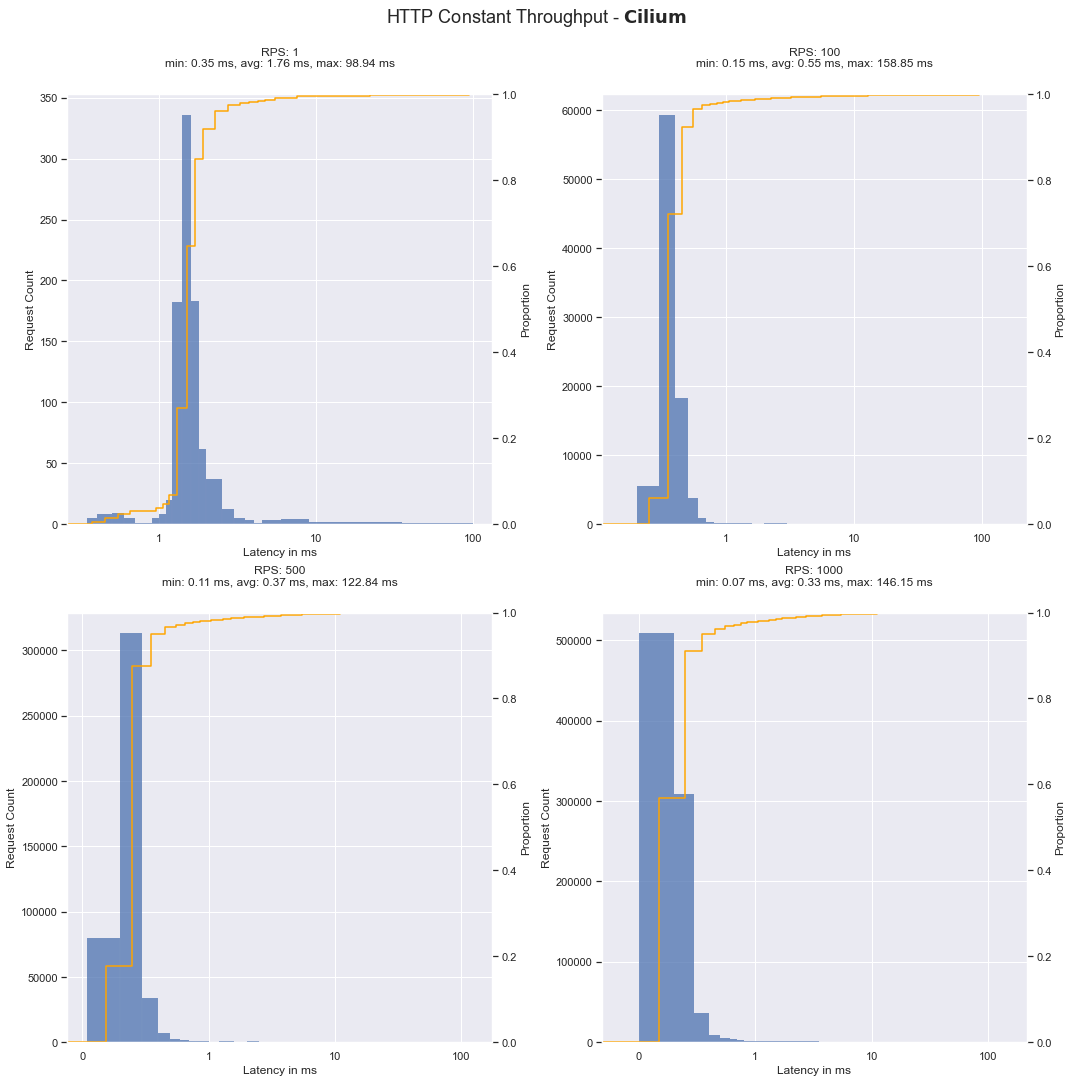

In [9]:

fig = create_constant_throughput_figure("cilium", "b")
fig.savefig(plot_dir / "exp_02-latency-cilium-results.pdf")
fig.show()

/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/2336531953.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


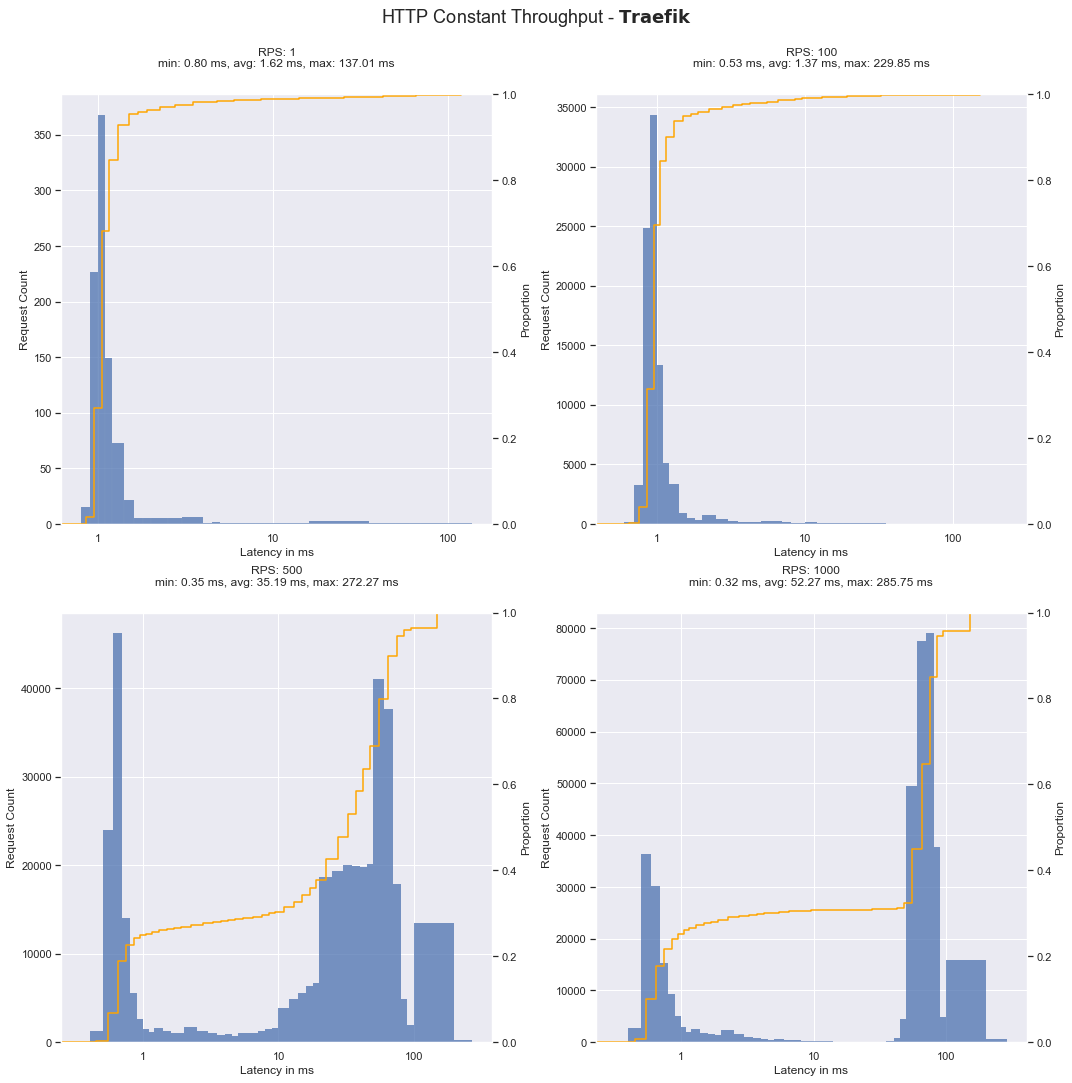

In [10]:

fig = create_constant_throughput_figure("traefik", "b")
fig.savefig(plot_dir / "exp_02-latency-traefik-results.pdf")
fig.show()

In [11]:
"""
Plotting of the results
- Create grid of subplots
- Plot figures on logarithmic scale (because of outliers)
- Plot Constant Throughput per mesh
"""

def plot_http_constant_throughput(mesh: str, data:pd.DataFrame, axes: matplotlib.axes) -> None:
    # Plot each row as subplot
    for i ,(_, row) in enumerate(data.iterrows()):
        ax = axes[i]

        # Plot data
        binedges = np.array(row["bins"])
        weights = np.array(row["counts"])
        x = (binedges[1:] + binedges[:-1]) / 2.0

        sns.histplot(data=row, x=x, bins=binedges, weights=weights, color="b", ax=ax)

        # Labels
        plot_title = (
            f"$\\bf{mesh}$\n"
            f"RPS: {row['RequestedQPS']}\n"
            f"min: {row['Min']:.2f} ms, avg: {row['Avg']:.2f} ms, max: {row['Max']:.2f} ms"
        )
        ax.set_ylabel("Request Count")
        ax.set_xlabel("Latency in ms")
        ax.set_title(plot_title, y=1.05)


        # Y AXIS
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


        # X AXIS
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


        # # Second plot with cumulative density
        ax2 = ax.twinx()
        ax2.set_alpha(0.5)
        ax2.grid(False)
        sns.ecdfplot(data=row, x=x, weights=weights, color="orange", ax=ax2)


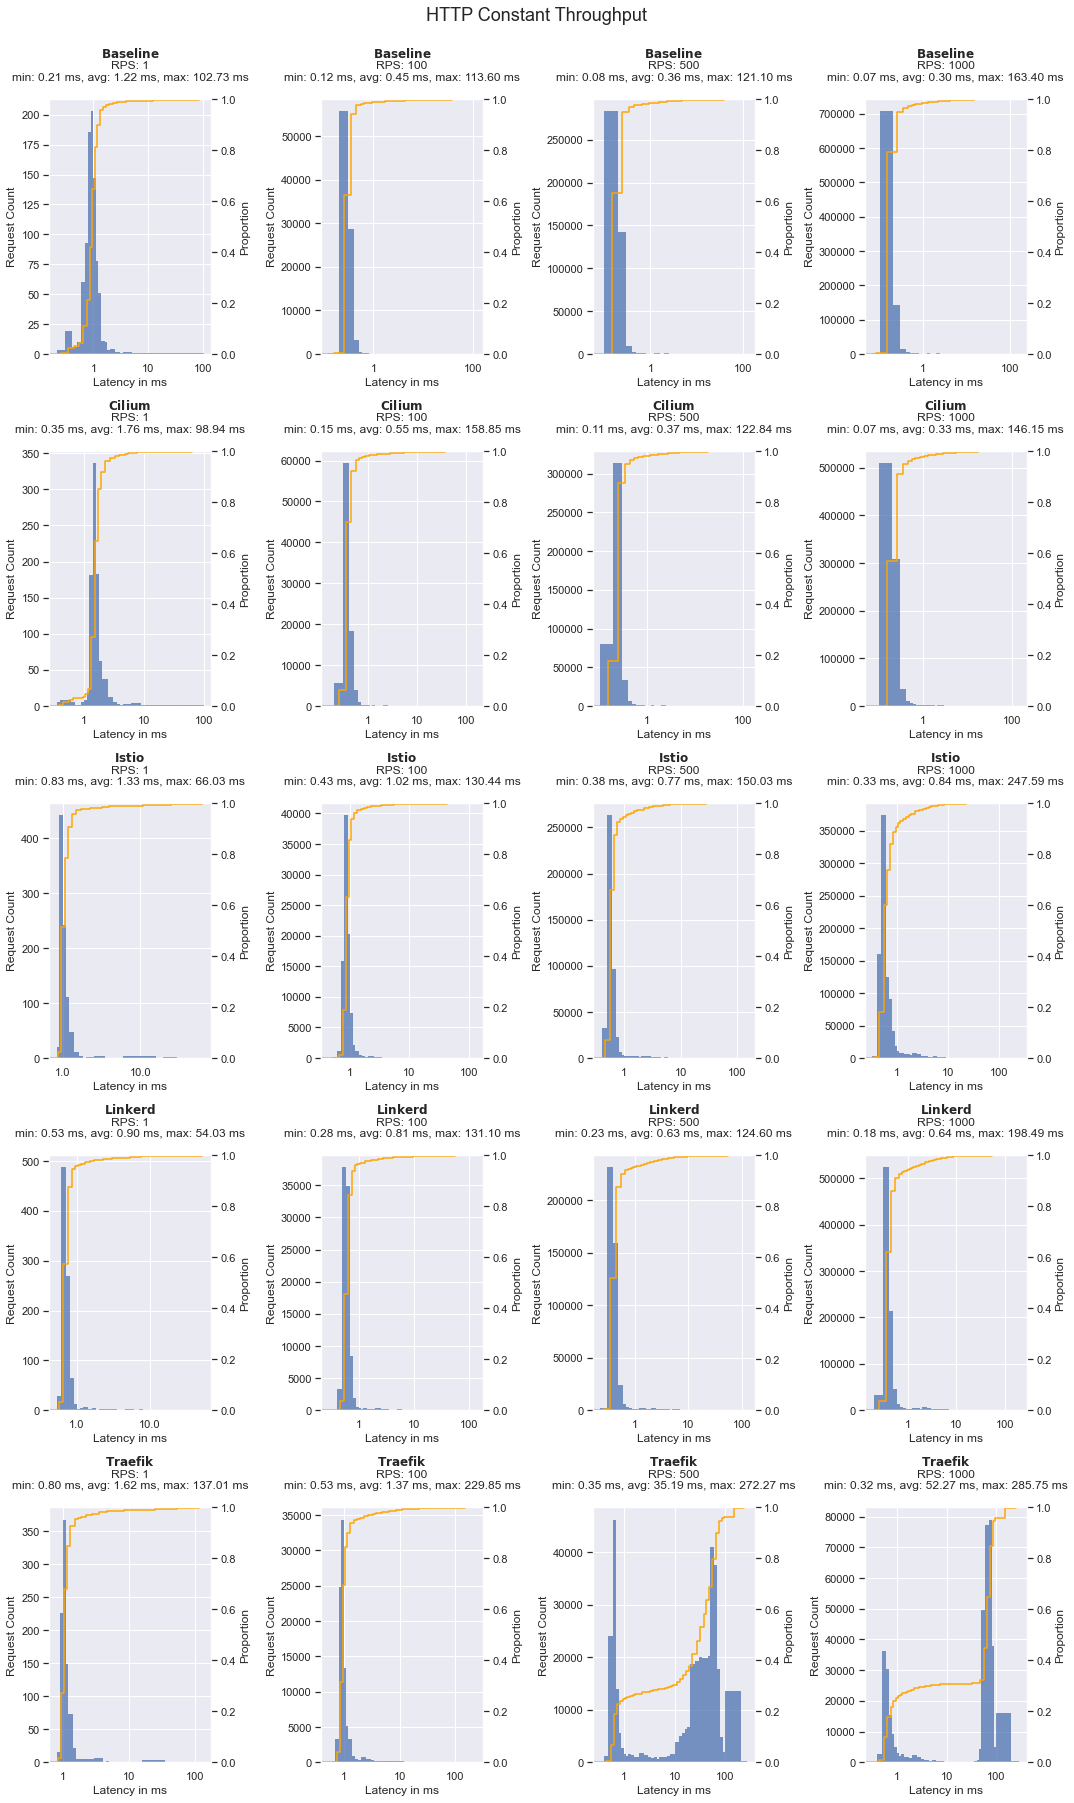

In [12]:
# Combined results

# Create grid of plots 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 25))

# Set figure title
fig.suptitle(f"HTTP Constant Throughput", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    plot_http_constant_throughput(mesh=m.capitalize(), data=data, axes=axes[i])

fig.tight_layout()
fig.savefig(plot_dir / "exp_02-latency-combined-results.pdf")


In [13]:

from typing import List, TypedDict

# Represents a single data point of system utilization
class ResourceResult(TypedDict):
    mesh: str
    qps: str
    pod: str
    container: str
    time: int
    cpu: float
    mem: float



def parse_resource_results(result_file: pathlib.Path) -> List[ResourceResult]:
    """ Reads a result file and parses the data.

    The returned data is a list of ResourceResults that represent a
    single metric over a time span of 15 minutes.
    """
    rows = []

    # Regex to extra# 0 -> Full match
    # 1 -> mem/cpu results
    # 2 -> Mesh
    # 3 -> Requested QPS
    name_re = re.compile("^(mem|cpu)_([a-z]+)_(\d+|MAX).*json$")

    # Extract metadata from the result
    matches = name_re.match(file)

    metric = matches[1]
    mesh = matches[2]
    qps = matches[3]

    with open(result_file) as f:
        data = json.load(f)

    # The resutl is lister per pod/container
    for container in data:

        # Metadata (dimensions)
        meta = container["metric"]

        # Actual values in list[unixtime, value]
        values = container["values"]

        for v in values:
            row: ResourceResult = {
                "mesh": mesh,
                "qps": qps,
                "pod": meta["pod"],
                "container": meta["container"],
                "time": v[0],
                metric: v[1],
            }
            rows.append(row)

    return rows


In [14]:
"""
Generate a list of rows containing a single metric (either cpu or mem)
These later have to be merged based on time
"""


results = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip non system resource files
        if not re.match("^(mem|cpu).*$", file):
            continue

        path = (pathlib.Path(root) / file).resolve()
        res = parse_resource_results(path)
        results.extend(res)


Parsing Experiment results:
Exp: 02_http_constant_throughput
Results: 60


In [15]:

""" Create a pandas DataFrame
- Each row represents a single observation
- Each observation takes a form of type ResourceResult
- Rows are merged based on time/pod/container -> this halves rows as both CPU/mem metrics share unix timestamps
- Convert unix timestamps to pd.DateTime
"""


# Initial dataset
df = pd.DataFrame(data=results)

# Merged CPU/mem results
df = df.groupby(by=["mesh", "qps", "pod", "container", "time"], as_index=False).first()

# Convert time column to datetime
df["date"] = pd.to_datetime(df["time"],unit="s")
df["cpu"] = pd.to_numeric(df["cpu"])
df["mem"] = pd.to_numeric(df["mem"])
df["mem_kb"] = df["mem"] / 1000
df["mem_mb"] = df["mem_kb"] / 1000

df

,mesh,qps,pod,container,time,cpu,mem,date,mem_kb,mem_mb
0,baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254846,0.890197,183329.848074,2022-06-26 14:47:26,183.329848,0.183330
1,baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254849,0.863798,177893.136284,2022-06-26 14:47:29,177.893136,0.177893
2,baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254852,0.848032,120340.086656,2022-06-26 14:47:32,120.340087,0.120340
3,baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254855,0.821574,116585.442912,2022-06-26 14:47:35,116.585443,0.116585
4,baseline,1,target-fortio-746f85d498-tmrfm,fortio,1656254858,0.677814,173817.135877,2022-06-26 14:47:38,173.817136,0.173817
...,...,...,...,...,...,...,...,...,...,...
13239,traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324778,0.198863,578302.158273,2022-06-27 10:12:58,578.302158,0.578302
13240,traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324781,0.198863,578302.158273,2022-06-27 10:13:01,578.302158,0.578302
13241,traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324784,0.198863,578302.158273,2022-06-27 10:13:04,578.302158,0.578302
13242,traefik,500,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656324787,0.198863,578302.158273,2022-06-27 10:13:07,578.302158,0.578302


In [16]:
import matplotlib
import matplotlib.ticker as ticker


def plot_cpu_usage(ax: matplotlib.axes, mesh: str, data: pd.DataFrame) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y: CPU usage in fractios of a CPU core per second
    x: date
    """

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(data=data, x=time_delta, y="cpu", hue="qps", ax=ax)

    # Labels
    plot_title = (
        f"$\\bf{mesh.capitalize()}$\n"
    )
    ax.set_ylabel("CPU usage")
    ax.set_xlabel("Time in minutes")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 15 minutes
    # Minor tick -> Every 5 minutes
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.set_xticklabels(np.arange(0, 61, 15))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(3))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Removes spacing at x limits
    delta_array = time_delta.to_numpy()
    # ax.set_xlim(left=delta_array[0], right=delta_array[-1])
    
    # Y axis configuration
    ax.set_ylim(bottom=0, top=0.5)


    # Mark warmup area
    # ax.axvspan(delta_array[0], delta_array[25], color="orange", alpha=0.85)

    # Place legend above axes
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center")

    return ax

In [17]:

import matplotlib
import matplotlib.ticker as ticker


def plot_cpu_usage(ax: matplotlib.axes, mesh: str, data: pd.DataFrame) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y: CPU usage in fractios of a CPU core per second
    x: date
    """

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(data=data, x=time_delta, y="cpu", hue="qps", ax=ax)

    # Labels
    plot_title = (
        f"$\\bf{mesh.capitalize()}$\n"
    )
    ax.set_ylabel("CPU usage")
    ax.set_xlabel("Time (minutes)")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 15 minutes
    # Minor tick -> Every 5 minutes
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.set_xticklabels(np.arange(0, 61, 15))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(3))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Removes spacing at x limits
    delta_array = time_delta.to_numpy()
    # ax.set_xlim(left=delta_array[0], right=delta_array[-1])
    
    # Y axis configuration
    ax.set_ylim(bottom=0, top=0.5)


    # Mark warmup area
    # ax.axvspan(delta_array[0], delta_array[25], color="orange", alpha=0.85)

    # Place legend above axes
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center")

    return ax

In [18]:
import matplotlib
import matplotlib.ticker as ticker


def plot_memory_usage(ax: matplotlib.axes, mesh: str, data: pd.DataFrame) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y: Memory usage in kb
    x: date
    """

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(data=data, x=time_delta, y="mem_kb", hue="qps", ax=ax)

    # Labels
    plot_title = (
        f"$\\bf{mesh.capitalize()}$\n"
    )
    ax.set_ylabel("Memory usage (KB)")
    ax.set_xlabel("Time (minutes)")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 15 minutes
    # Minor tick -> Every 5 minutes
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax.set_xticklabels(np.arange(0, 61, 15))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(3))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Removes spacing at x limits
    delta_array = time_delta.to_numpy()
    # ax.set_xlim(left=delta_array[0], right=delta_array[-1])
    
    # Y axis configuration
    ax.set_ylim(bottom=0, top=3200)


    # Mark warmup area
    # ax.axvspan(delta_array[0], delta_array[25], color="orange", alpha=0.85)

    # Place legend above axes
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center")

    return ax

/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/3228190971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/3228190971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/3228190971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/3228190971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/3228190971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 

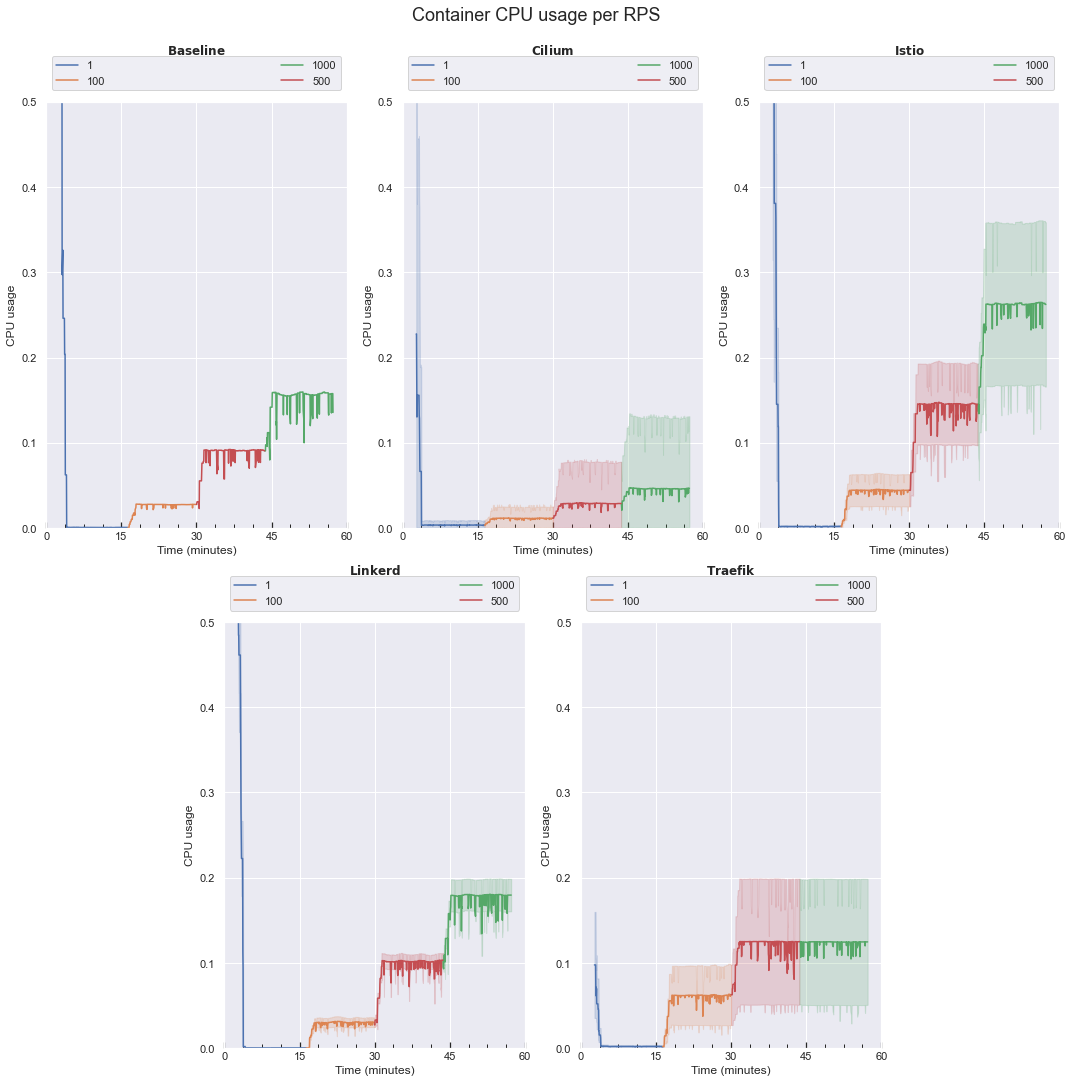

In [19]:
"""Plot CPU utilization results"""

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Container CPU usage per RPS", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    plot_cpu_usage(ax=axes[i], mesh=m, data=data)

fig.tight_layout()
fig.savefig(plot_dir / "exp_02-cpu-results.pdf")
plt.show()



/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/1119359497.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/1119359497.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/1119359497.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/1119359497.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 15))
/var/folders/xg/7l553jfx6xj12zrd4774v79h0000gn/T/ipykernel_88547/1119359497.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 61, 

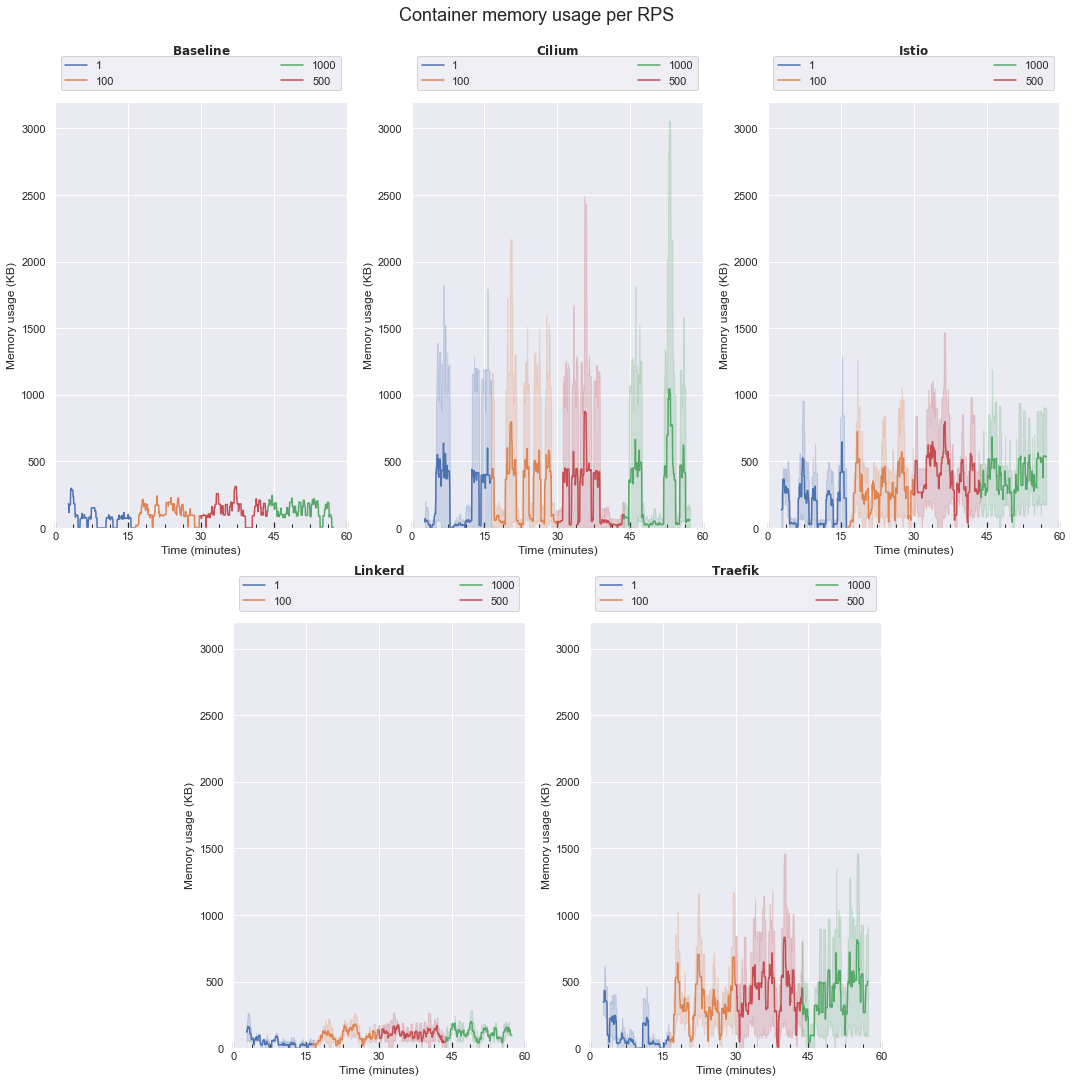

In [20]:

"""Plot memory utilization results"""

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Container memory usage per RPS", fontsize=18, y=1)

meshes = df["mesh"].unique()
meshes.sort()
meshes

for i, m in enumerate(meshes):
    # Subset dataframe
    data = df[df["mesh"] == m]

    plot_memory_usage(ax=axes[i], mesh=m, data=data)

fig.tight_layout()
fig.savefig(plot_dir / "exp_02-mem-results.pdf")
plt.show()

